In [76]:
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
import matplotlib as mpl
from importlib import reload
from vosk import Model
from Signal_Analysis.features.signal import get_HNR
from scipy import signal
from audiostretchy.stretch import stretch_audio
import pandas as pd

# tools work in progress
import tools

reload(tools)

plt.style.use("dark_background")
mpl.rcParams["lines.linewidth"] = 0.5
plt.close("all")

In [77]:
labels_path = (
    "example_speech_Andreas/180923214834-Y20UOTIE-text-000_vowels_timestamp_praat"
)

labels_df = pd.read_csv(labels_path)

## Speech recognition

0 i ------------------- from 0.3000 to 0.4200 sec, confidence: 100.00%
1 skymningen ---------- from 0.4200 to 1.2600 sec, confidence: 100.00%
2 en ------------------ from 1.3500 to 1.5000 sec, confidence: 100.00%
3 mycket -------------- from 1.5000 to 1.8000 sec, confidence: 100.00%
4 het ----------------- from 1.8300 to 2.1000 sec, confidence: 100.00%
5 dag ----------------- from 2.1000 to 2.4300 sec, confidence: 100.00%
6 i ------------------- from 2.4300 to 2.5200 sec, confidence: 100.00%
7 början -------------- from 2.5200 to 2.7900 sec, confidence: 100.00%
8 av ------------------ from 2.7900 to 2.9100 sec, confidence: 100.00%
9 juli ---------------- from 2.9100 to 3.3600 sec, confidence: 100.00%
10 lämnade ------------- from 3.3600 to 3.9900 sec, confidence: 100.00%
11 en ------------------ from 3.9900 to 4.1400 sec, confidence: 100.00%
12 ung ----------------- from 4.1400 to 4.4100 sec, confidence: 100.00%
13 man ----------------- from 4.4100 to 4.6800 sec, confidence: 100.00%
14

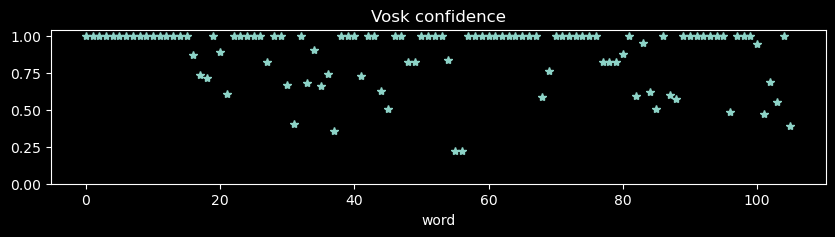

In [78]:
audio_path = "audio_preproc/180923214834-Y20UOTIE-text-000_pp.wav"

Fs, audio = wavfile.read(audio_path)
model_path = "models/vosk-model-small-sv-rhasspy-0.15/"

if "model" not in locals():
    model = Model(model_path)

words = tools.rec_vosk(audio_path, model, print_summary=True)

text = " ".join([w["word"] for w in words])

# get all vowels
for w in words:
    w["vowels"] = tools.checkVowels(w["word"], tools.VOWELS_SV)


print(text)
plt.figure(figsize=(10, 2))
plt.plot([w["conf"] for w in words], "*")
plt.title("Vosk confidence")
plt.xlabel("word")
plt.ylim(bottom=0)
plt.show()

## Guess where vowels should be

In [79]:
found_things = []
fl = int(0.02 * Fs)
print("fl =", fl)
for w in words:
    if w["conf"] >= 1:
        L = w["end"] - w["start"]
        for i, c in enumerate(w["word"]):
            if c in tools.VOWELS_SV:
                time = i / len(w["word"]) * L + w["start"]
                segment = audio[int(time * Fs - fl / 2) : int(time * Fs + fl / 2)]
                hnr = get_HNR(segment, Fs)
                found_things.append(
                    {
                        "vowel": c,
                        "time": time,
                        "hnr": hnr,
                        "segment": segment,
                    }
                )


found_df = pd.DataFrame.from_records(found_things).sort_values("hnr", ascending=False)
display(found_df.head(10))

MAX = 20

starts_all = found_df["time"][:MAX] - (fl / 2) / Fs
stops_all = found_df["time"][:MAX] + (fl / 2) / Fs
print("total found vowels:", len(starts_all))
print("unique start points:", len(np.unique(starts_all)))
tools.score_vs_labels(starts_all, stops_all, labels_df, snäll=True)

fl = 882


,vowel,time,hnr,segment
88,i,33.858750,28.506147,"[-1527, -1542, -1573, -1598, -1602, -1599, -15..."
107,i,43.540000,26.904725,"[153, 63, -68, -217, -359, -478, -562, -603, -..."
3,e,1.092000,21.397374,"[3945, 3653, 3363, 3071, 2770, 2467, 2162, 184..."
2,i,0.840000,20.013240,"[1760, 2217, 2637, 3020, 3385, 3747, 4093, 440..."
74,i,27.263333,19.303534,"[5877, 6317, 6674, 6946, 7126, 7245, 7338, 742..."
55,e,19.800000,18.292878,"[-3136, -3640, -4194, -4789, -5379, -5919, -63..."
34,o,10.470000,18.090410,"[-105, -181, -211, -198, -185, -209, -264, -32..."
32,å,9.785623,18.074843,"[-2272, -2718, -3139, -3545, -3937, -4297, -46..."
33,a,10.176696,17.003677,"[2674, 2239, 1808, 1399, 1017, 648, 275, -102,..."
87,ä,33.577500,16.985391,"[6901, 6285, 5797, 5497, 5471, 5775, 6388, 723..."


total found vowels: 20
unique start points: 20
included: 7
Assuming Praat perfect and all vowels correctly classified:
precision: 0.35
recall: 0.04


## find highest HNR

frame length    : 882 samples
frame length    : 0.02 seconds
between frames  : 0.02 seconds
number of frames: 2255


[ 766 2203 1371   51   55 1457 1212   46   36 1969 2061 1388  809   56
   48  171  243   43 1439  899   40  714 1408 1365   35   57 1372 1370
 1387   37  564 1956 2127 1581 1809  998  709  662  881  758 1769 1179
 1019   33   74 1615   45 1350  532  408  461   34 1161 1481  409  814
 1407 1155   53  523]

total found vowels: 60
unique start points: 60
included: 29
Assuming Praat perfect and all vowels correctly classified:
precision: 0.48333333333333334
recall: 0.1657142857142857


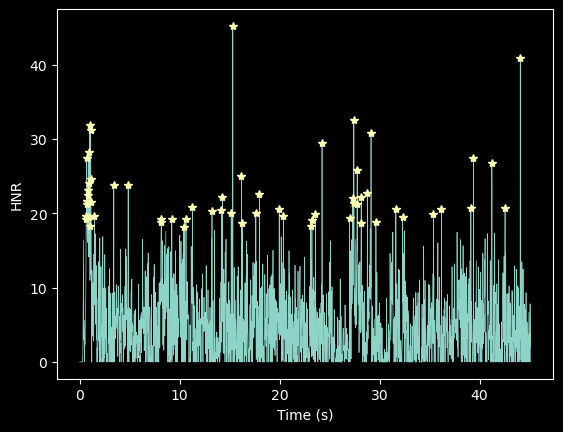

In [80]:
frames, f_start = tools.split_frames(audio, fl, Fs, overlap=int(0), print_info=True)
# frames = np.array()
MAX = 60

hnr_frames = np.array([get_HNR(f, Fs) for f in frames])
frames_highest_hnr = np.argsort(-hnr_frames)[:MAX]

plt.figure()
plt.plot(f_start / Fs, hnr_frames)
plt.plot(f_start[frames_highest_hnr] / Fs, hnr_frames[frames_highest_hnr], "*")
plt.xlabel("Time (s)")
plt.ylabel("HNR")
print(frames_highest_hnr)

out = tools.stitch_frames([frames[i] for i in frames_highest_hnr], padding=Fs / 4)

wavfile.write("output/test_largeHNR.wav", Fs, out)

print()
starts_all_B = f_start[frames_highest_hnr] / Fs
stops_all_B = (f_start[frames_highest_hnr] + fl) / Fs
print("total found vowels:", len(starts_all_B))
print("unique start points:", len(np.unique(starts_all_B)))
tools.score_vs_labels(starts_all_B, stops_all_B, labels_df, snäll=True)

### match to vowels

a
i
a
e
e
i
a
i
i
a
e
o
i
e
e
ä
i
i
i
o
i
i
o
i
y
e
a
a
o
i
e
e
a
o
e
ö
y
y
a
a
e
a
a
y
y
i
i
ä
o
u
o
y
e
u
u
i
o
a
e
o
total found vowels: 39
unique start points: 39
unique stop points: 39
included: 17
Assuming Praat perfect and all vowels correctly classified:
precision: 0.4358974358974359
recall: 0.09714285714285714


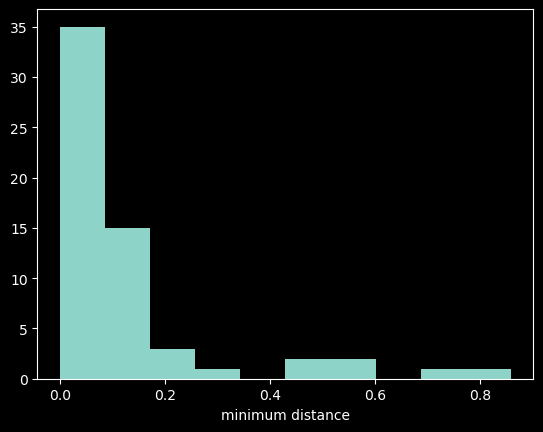

In [81]:
reload(tools)


def match_vowel_times(starts, stops, found_df: pd.DataFrame, max_lag=0.1):
    """Match starts and stops (seconds) to vowel timestamps.
    ## Parameters
    starts, stops: list
    found_df: DataFrame
        contains vowel labels, time (midpoint), hnr, and segment. For some frames.

    ## Returns
    grouped_frames: dict[dict[list]]
        contains, for each vowel, lists of frames, starts and stops.
    """
    grouped_frames = {v: {} for v in tools.VOWELS_SV}
    # initialize lists
    for v in grouped_frames.keys():
        grouped_frames[v]["frame"] = []
        grouped_frames[v]["start"] = []
        grouped_frames[v]["stop"] = []

    min_diffs = []
    for start, stop in zip(starts, stops):
        mid = np.mean((start, stop))
        # time difference to vowels from vosk
        diffs = found_df["time"].map(lambda t: np.abs(t - mid))
        min_d = diffs.min()
        idx = diffs.idxmin()
        min_diffs.append(min_d)

        vowel = found_df.loc[idx, "vowel"]
        print(vowel)

        if min_d <= max_lag:
            grouped_frames[vowel]["frame"].append(found_df["segment"])
            grouped_frames[vowel]["start"].append(start)
            grouped_frames[vowel]["stop"].append(stop)

    plt.figure()
    plt.hist(min_diffs)
    plt.xlabel("minimum distance")
    return grouped_frames


grouped_frames = match_vowel_times(starts_all_B, stops_all_B, found_df)

starts_all_C, stops_all_C, vowels_all_C = tools.groupedframes_to_lists(grouped_frames)

tools.score_vs_labels(starts_all_C, stops_all_C, labels_df, snäll=True)
